# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep learning libraries
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

# Reading The Data

In [2]:
data_dir = '/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv'
df = pd.read_csv(data_dir, index_col='date', parse_dates=True)

# Data Exploration

In [3]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [6]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


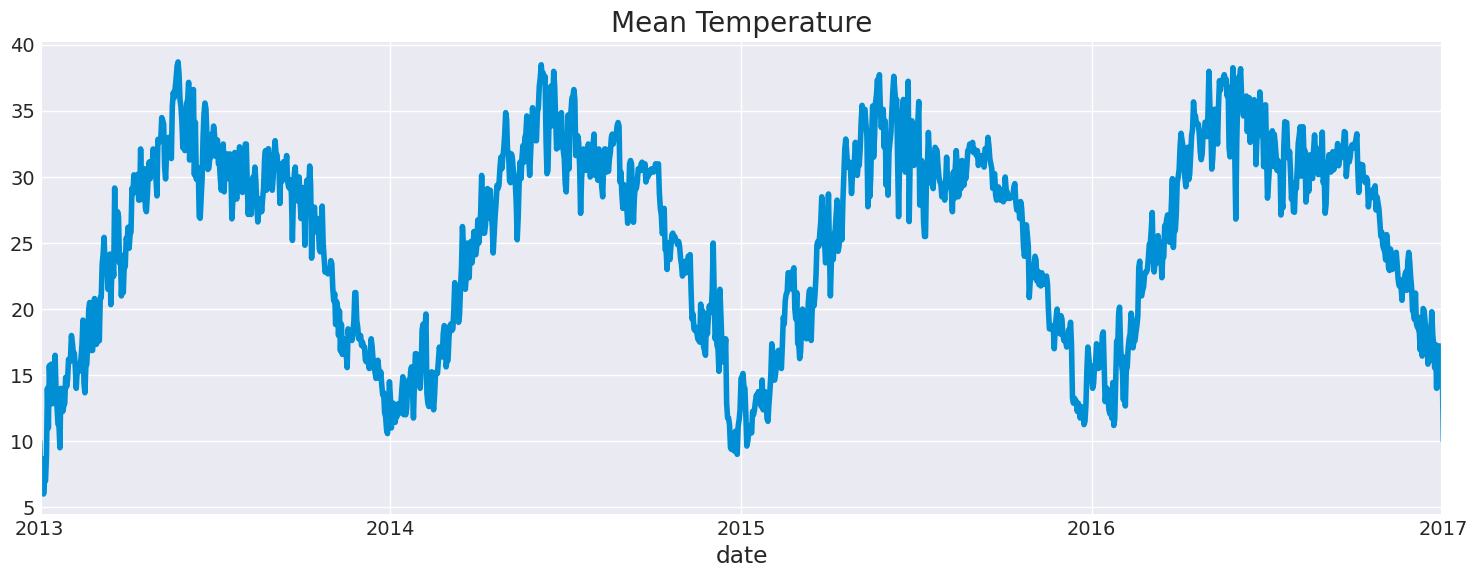

In [7]:
plt.figure(figsize=(15, 6))
df['meantemp'].plot()
plt.title("Mean Temperature")
plt.tight_layout()
plt.show()

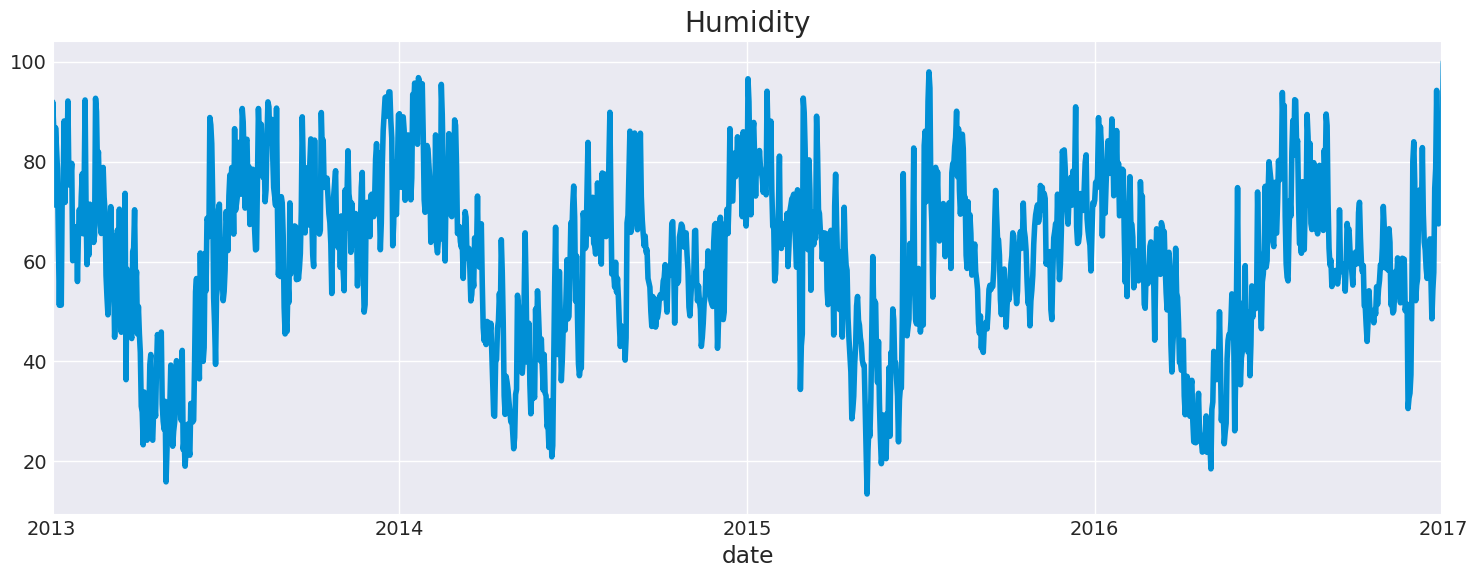

In [8]:
plt.figure(figsize=(15, 6))
df['humidity'].plot()
plt.title("Humidity")
plt.tight_layout()
plt.show()

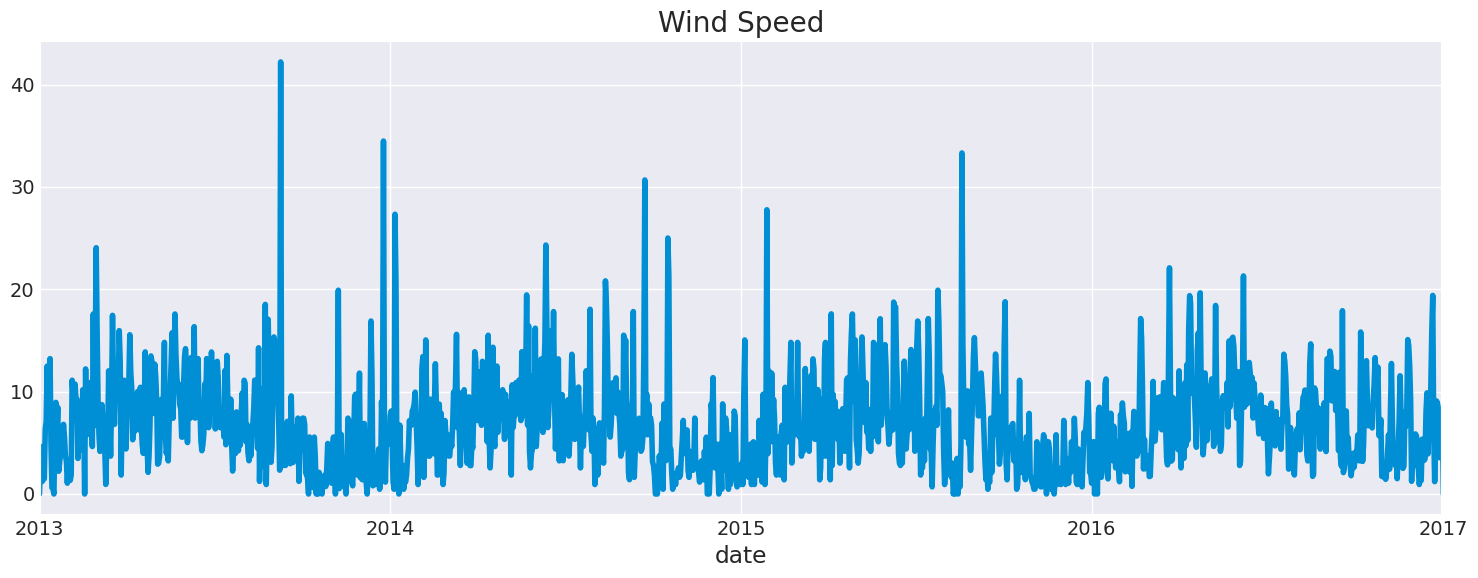

In [9]:
plt.figure(figsize=(15, 6))
df['wind_speed'].plot()
plt.title("Wind Speed")
plt.tight_layout()
plt.show()

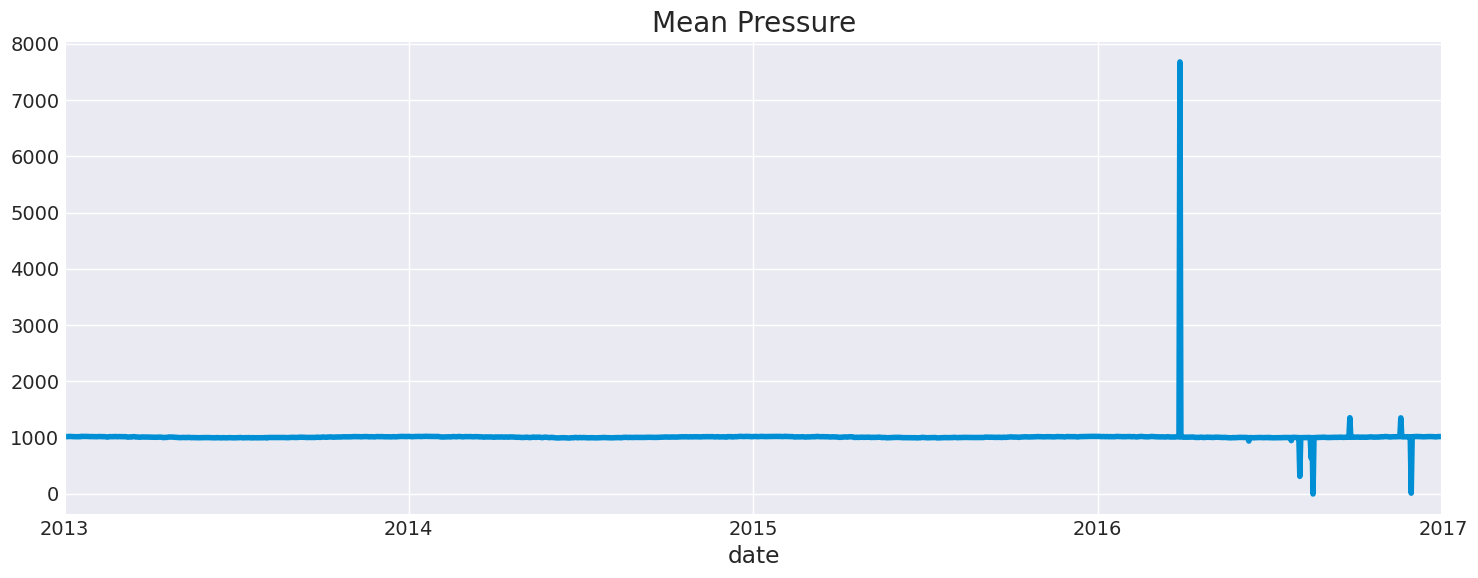

In [10]:
plt.figure(figsize=(15, 6))
df['meanpressure'].plot()
plt.title("Mean Pressure")
plt.tight_layout()
plt.show()

# Data Preprocessing

## Choosing Prediction Column

In [11]:
dataset = df['meantemp']
dataset = pd.DataFrame(dataset)

data = dataset.values
data.shape

(1462, 1)

## Normalizing Data

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

## Splitting The Data

In [13]:
# 75% to Train, 25% to Test
train_size = int(len(data) * .75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [14]:
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-60: , :]
train_data.shape

(1096, 1)

## Creating training set

In [15]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [16]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
x_train.shape, y_train.shape

((1036, 60, 1), (1036,))

# LSTM Model

## Model Structure

In [19]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1) ),
    LSTM(64, return_sequences=False),
    
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss= 'mse', metrics=['mean_absolute_error'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [21]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [22]:
# Fitting the LSTM to the Training set
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=early_stopping)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.1026 - mean_absolute_error: 0.2454
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0081 - mean_absolute_error: 0.0727
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0053 - mean_absolute_error: 0.0571
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0048 - mean_absolute_error: 0.0552
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0051 - mean_absolute_error: 0.0562
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0051 - mean_absolute_error: 0.0558
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0047 - mean_absolute_error: 0.0547
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0044 - mean_absolute_error: 0.0523
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0047 - mean_absolute_error: 0.0533
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0045 - mean_absolute_error: 0.0529
Epoch 11/100
33/33 ━━━━━━━━━━

## Model Evaluation

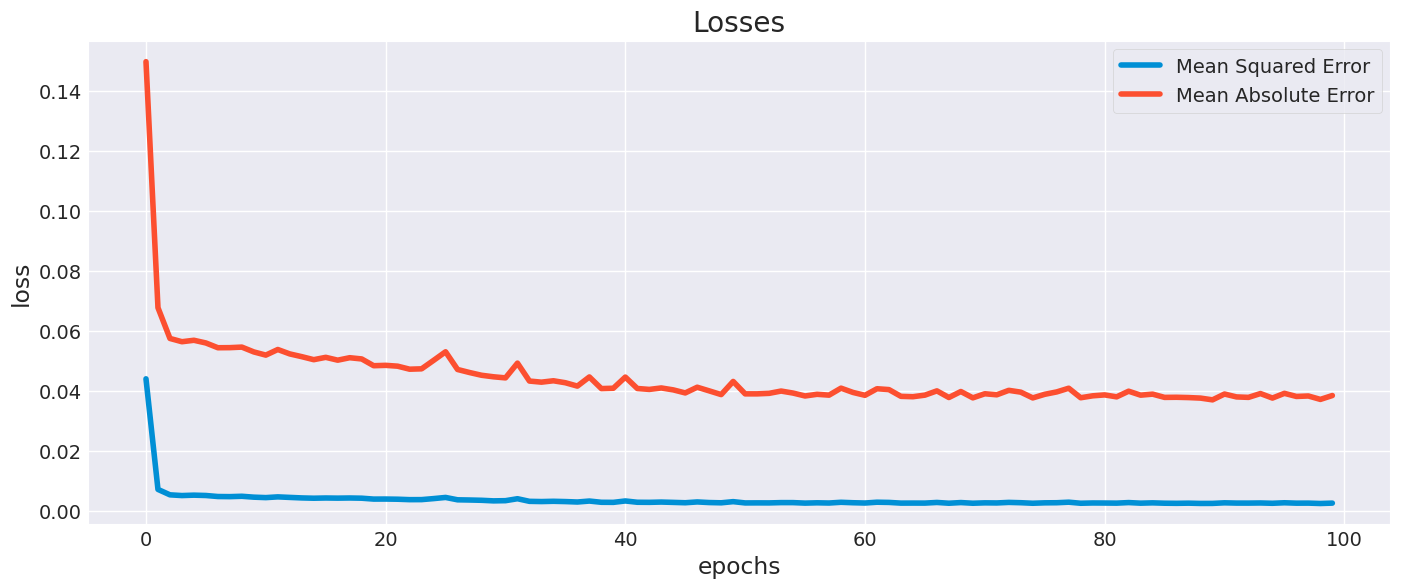

In [23]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Mean Squared Error', 'Mean Absolute Error'])
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Predection

## Creating testing set

In [24]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [25]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [26]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [27]:
x_test.shape, y_test.shape

((366, 60, 1), (366,))

In [28]:
# inverse y_test scaling 
predictions = model.predict(x_test)

# inverse predictions scaling 
predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


(366, 1)

## Root mean square error

In [29]:
# inverse y_test scaling 
y_test = scaler.inverse_transform([y_test])

RSME = np.sqrt(np.mean( y_test - predictions)**2).round(2)
RSME

0.64

In [30]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,14.953010,14.000000
1,14.443290,14.375000
2,14.566899,15.750000
3,15.514075,15.833333
4,15.788527,17.375000
...,...,...
361,17.188646,17.217391
362,17.404625,15.238095
363,16.112881,14.095238
364,15.045273,15.052632


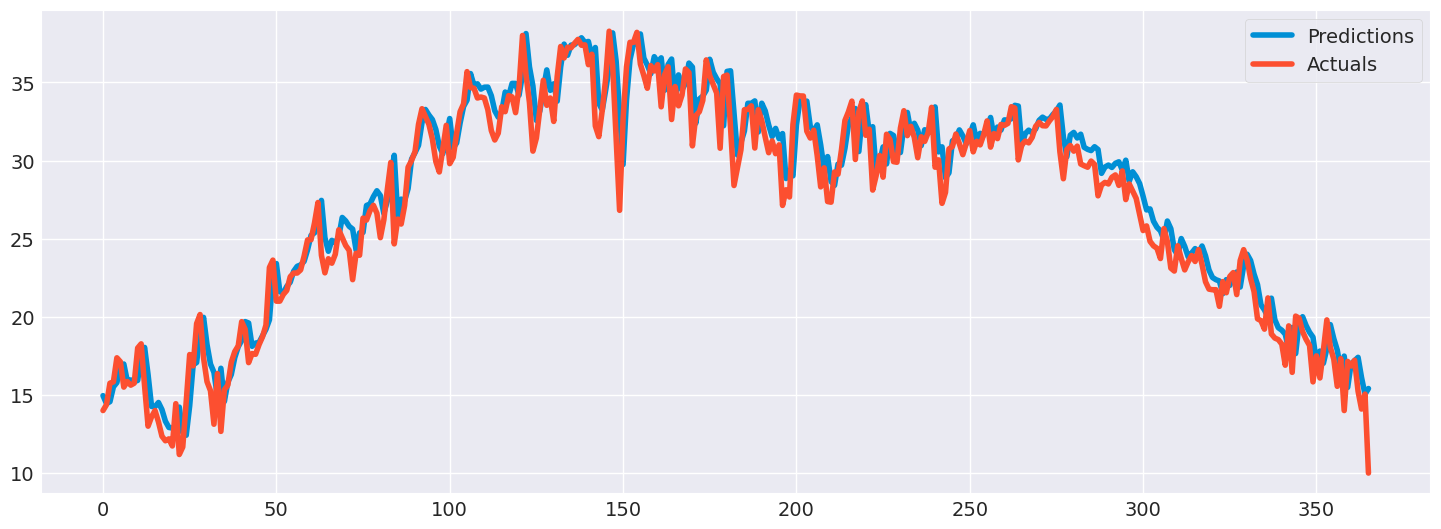

In [31]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

## Visualize Predictions with The Data

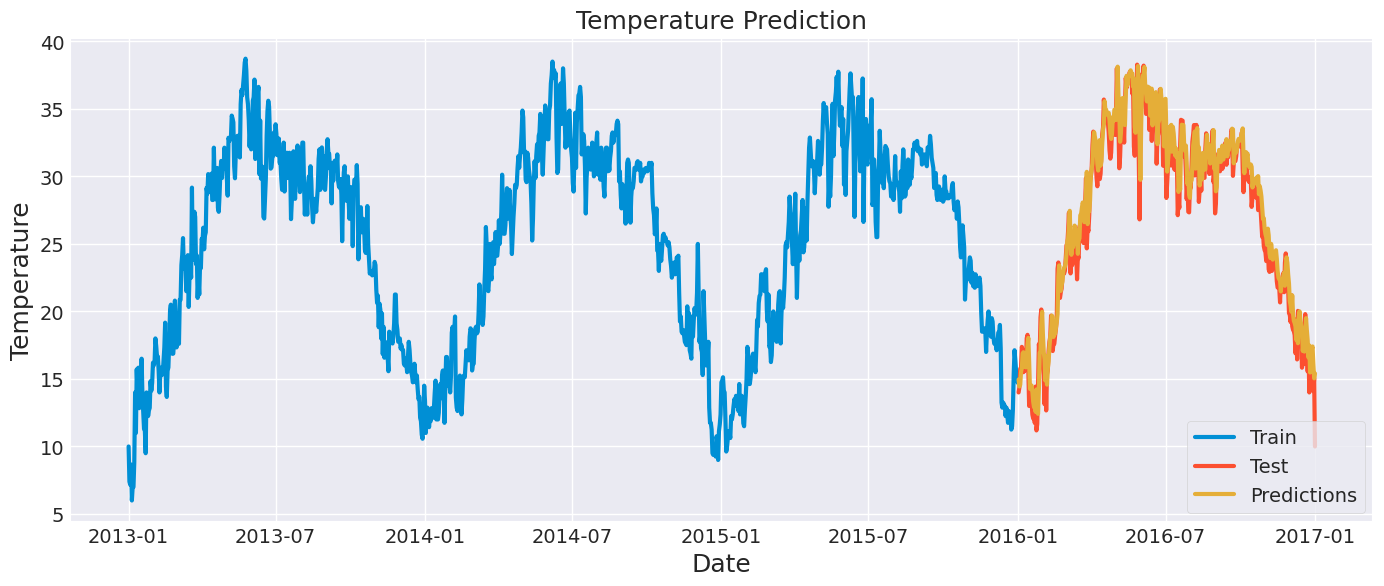

In [32]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (15, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])
plt.show()

# Multivariate Predection

In [33]:
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [34]:
data = df.values
data.shape

(1462, 4)

## Data Preprocessing

### Data Normalization

In [35]:
scaled_data = scaler.fit_transform(data)

### Data Splitting

In [36]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size-60:, :]

Train Size : 1096 Test Size : 366


In [37]:
print('Shape of Train Data : ', train_data.shape)
print('Shape of Test Data', test_data.shape)

Shape of Train Data :  (1096, 4)
Shape of Test Data (426, 4)


### Creating Train Data

In [38]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :4])
    y_train.append(train_data[i, :4])

In [39]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [40]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 4))

In [41]:
x_train.shape, y_train.shape

((1036, 60, 4), (1036, 4))

## Model Structure

In [42]:
model2 = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 4)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(4)
])

model2.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

In [43]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,116 (168.42 KB)

 Trainable params: 43,116 (168.42 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [44]:
early_stopping = EarlyStopping(
    patience=10,
    monitor='loss',
    restore_best_weights=True
)

In [45]:
# Fitting the LSTM to the Training set
history2 = model2.fit(x_train, y_train, epochs= 100, batch_size= 32, callbacks=early_stopping)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0723 - mean_absolute_error: 0.1922
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0085 - mean_absolute_error: 0.0644
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0082 - mean_absolute_error: 0.0643
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0076 - mean_absolute_error: 0.0607
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0075 - mean_absolute_error: 0.0589
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0075 - mean_absolute_error: 0.0612
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0075 - mean_absolute_error: 0.0581
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0072 - mean_absolute_error: 0.0562
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0074 - mean_absolute_error: 0.0572
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0072 - mean_absolute_error: 0.0558
Epoch 11/100
33/33 ━━━━━━━━━━

## Model Evaluation

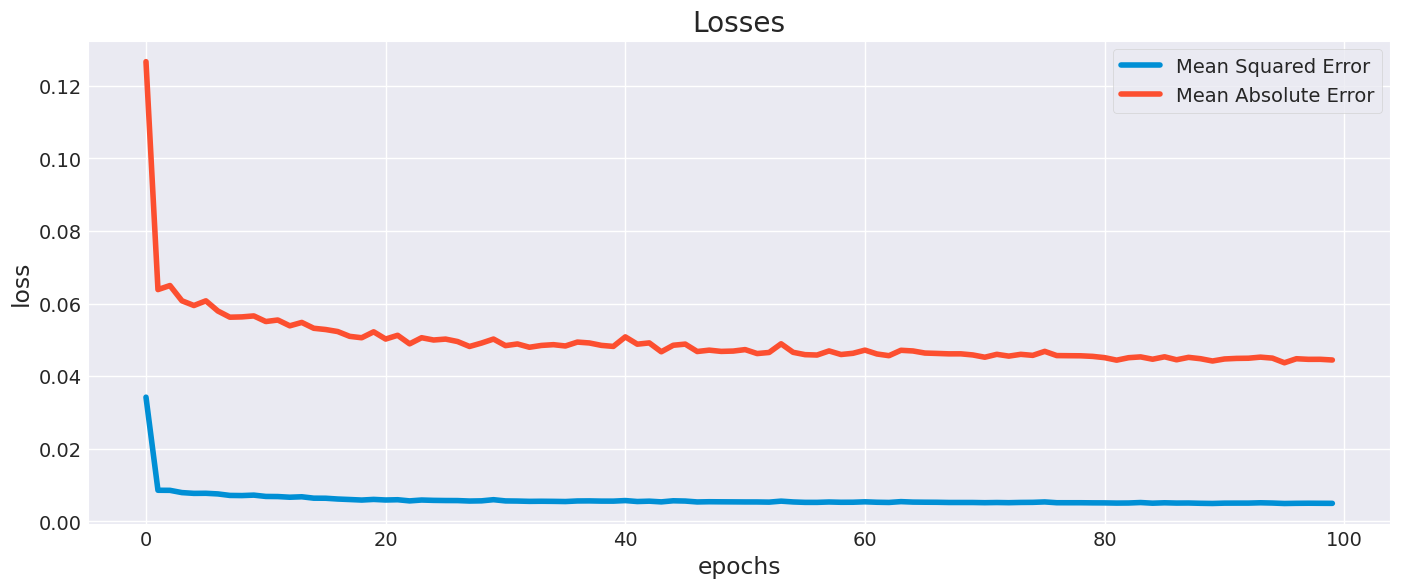

In [46]:
plt.figure(figsize=(15,6))
plt.plot(history2.history['loss'])
plt.plot(history2.history['mean_absolute_error'])
plt.legend(['Mean Squared Error', 'Mean Absolute Error'])
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Prediction

### Creating Test Data

In [47]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i , :4])
    y_test.append(test_data[i , :4])

In [48]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [49]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 4))

In [50]:
x_test.shape , y_test.shape

((366, 60, 4), (366, 4))

In [51]:
# Get Prediction
predictions = model2.predict(x_test)

# inverse predictions scaling 
predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


(366, 4)

In [52]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

In [53]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

5.06

# Forecast Next 30 Days

In [54]:
from datetime import timedelta

In [55]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [56]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []

for i in range(0, future):
    out = model2.predict(Xin, batch_size=5)
    forcast.append(out[0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([0.28046346, 0.7648393 , 0.1209655 , 0.1331863 ], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([0.28046346, 0.7648393 , 0.1209655 , 0.1331863 ], dtype=float32), array([0.34238958, 0.40489998, 0.18304537, 0.13058367], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[array([0.28046346, 0.7648393 , 0.1209655 , 0.1331863 ], dtype=float32), array([0.34238958, 0.40489998, 0.18304537, 0.13058367], dtype=float32), array([0.34730315, 0.48920912, 0.1702848 , 0.13300465], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([0.28046346, 0.7648393 , 0.1209655 , 0.1331863 ], dtype=float32), array([0.34238958, 0.40489998, 0.18304537, 0.13058367], dtype=float32), array([0.34730315, 0.48920912, 0.1702848 , 0.13300465], dtype=float32), array([0.37431207, 0.47747868, 0.17278464, 0.13298285], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[array([0.28046346, 0.7648393 , 0.1209655 , 0.1331863 ], dtype=float32), array([0.3423

In [57]:
time

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2017-01-02 00:00:00'),
 Timestamp('2017-01-03 00:00:00'),
 Timestamp('2017-01-04 00:00:00'),
 Timestamp('2017-01-05 00:00:00'),
 Timestamp('2017-01-06 00:00:00'),
 Timestamp('2017-01-07 00:00:00'),
 Timestamp('2017-01-08 00:00:00'),
 Timestamp('2017-01-09 00:00:00'),
 Timestamp('2017-01-10 00:00:00'),
 Timestamp('2017-01-11 00:00:00'),
 Timestamp('2017-01-12 00:00:00'),
 Timestamp('2017-01-13 00:00:00'),
 Timestamp('2017-01-14 00:00:00'),
 Timestamp('2017-01-15 00:00:00'),
 Timestamp('2017-01-16 00:00:00'),
 Timestamp('2017-01-17 00:00:00'),
 Timestamp('2017-01-18 00:00:00'),
 Timestamp('2017-01-19 00:00:00'),
 Timestamp('2017-01-20 00:00:00'),
 Timestamp('2017-01-21 00:00:00'),
 Timestamp('2017-01-22 00:00:00'),
 Timestamp('2017-01-23 00:00:00'),
 Timestamp('2017-01-24 00:00:00'),
 Timestamp('2017-01-25 00:00:00'),
 Timestamp('2017-01-26 00:00:00'),
 Timestamp('2017-01-27 00:00:00'),
 Timestamp('2017-01-28 00:00:00'),
 Timestamp('2017-01-

In [58]:
forcast

[array([0.28046346, 0.7648393 , 0.1209655 , 0.1331863 ], dtype=float32),
 array([0.34238958, 0.40489998, 0.18304537, 0.13058367], dtype=float32),
 array([0.34730315, 0.48920912, 0.1702848 , 0.13300465], dtype=float32),
 array([0.37431207, 0.47747868, 0.17278464, 0.13298285], dtype=float32),
 array([0.39796603, 0.48014876, 0.17574118, 0.13456017], dtype=float32),
 array([0.42026573, 0.47783595, 0.18058833, 0.13670702], dtype=float32),
 array([0.43993038, 0.47502625, 0.18550831, 0.13923986], dtype=float32),
 array([0.45665854, 0.47258154, 0.18947835, 0.14185704], dtype=float32),
 array([0.470279  , 0.47131237, 0.19194478, 0.14434753], dtype=float32),
 array([0.48081043, 0.47130048, 0.19282952, 0.14656717], dtype=float32),
 array([0.48843253, 0.47227013, 0.19232142, 0.14843722], dtype=float32),
 array([0.49347726, 0.47380975, 0.19073752, 0.14992724], dtype=float32),
 array([0.4963791 , 0.47550878, 0.18846117, 0.15104051], dtype=float32),
 array([0.49764684, 0.4770808 , 0.18584165, 0.15180

In [59]:
forcasted_output = np.array(forcast)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [60]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", 'meantemp', 'humidity', 'wind_speed', 'meanpressure'
df_result.head()

,Date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.175161,79.641800,5.107163,1020.145447
1,2017-01-02,17.201031,48.481342,7.728176,1000.151123
2,2017-01-03,17.361774,55.780102,7.189424,1018.749939
3,2017-01-04,18.245352,54.764580,7.294968,1018.582458
4,2017-01-05,19.019175,54.995735,7.419793,1030.700073


In [61]:
df_result.set_index('Date', inplace=True)

In [62]:
df_result.head()

,meantemp,humidity,wind_speed,meanpressure
Date,,,,
2017-01-01,15.175161,79.641800,5.107163,1020.145447
2017-01-02,17.201031,48.481342,7.728176,1000.151123
2017-01-03,17.361774,55.780102,7.189424,1018.749939
2017-01-04,18.245352,54.764580,7.294968,1018.582458
2017-01-05,19.019175,54.995735,7.419793,1030.700073


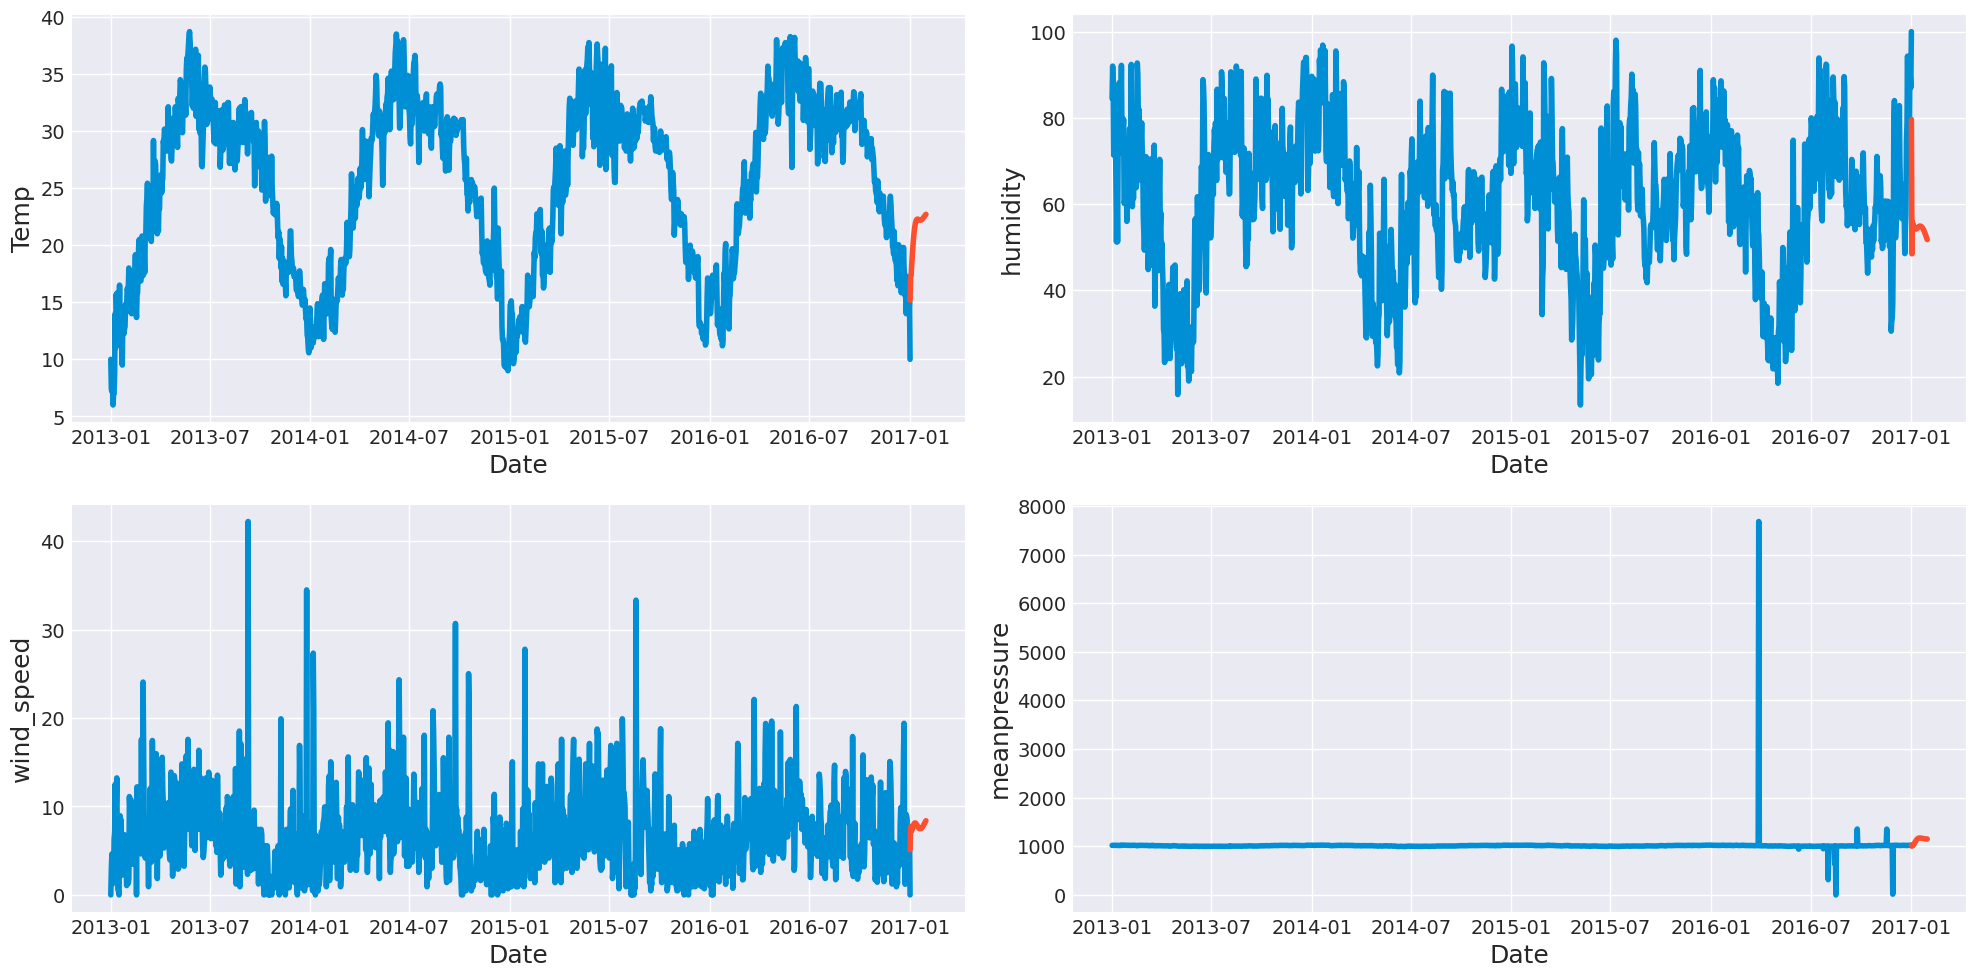

In [63]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(df['meantemp'])
plt.plot(df_result[['meantemp']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temp' ,fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(df['humidity'])
plt.plot(df_result[['humidity']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('humidity' ,fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(df['wind_speed'])
plt.plot(df_result[['wind_speed']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('wind_speed' ,fontsize=18)

plt.subplot(2, 2, 4)
plt.plot(df['meanpressure'])
plt.plot(df_result[['meanpressure']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('meanpressure' ,fontsize=18)

plt.tight_layout()
plt.show()